## Utils

### Visualization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from matplotlib.colors import ListedColormap

def show(image, instances=None, title=None, visualize_bboxes=True, figsize=(10, 15)):
    image_np = np.asarray(image)

    # Создаём фигуру
    plt.figure(figsize=figsize)
    plt.imshow(image_np)
    plt.axis('off')

    # Определяем цвета
    colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'cyan', 'magenta']
    colormap = ListedColormap(colors[:len(instances) if instances else 0])

    ax = plt.gca()

    # Визуализируем маски и вычисляем bounding boxes, если нужно
    if instances is not None:
        for i, instance in enumerate(instances):
            mask = instance.get('mask')
            bbox = instance.get('bbox')
            points = instance.get('points')
            score = instance.get('score')
            label = instance.get('text_label') or instance.get('label')

            color = colors[i % len(colors)]  # Выбор цвета

            if mask is not None:
                mask_colored = np.zeros((*mask.shape, 4))  # Для RGBA
                cmap_color = plt.colormaps.get_cmap(colormap)(i)  # Получение цвета
                mask_colored[..., :3] = cmap_color[:3]  # Устанавливаем RGB
                mask_colored[..., 3] = 0.3 * mask  # Прозрачность для наложения
                plt.imshow(mask_colored)

                if bbox is None:  # Вычисляем bbox из маски, если его нет
                    rows = np.any(mask, axis=1)
                    cols = np.any(mask, axis=0)
                    if np.any(rows) and np.any(cols):
                        y_min, y_max = np.where(rows)[0][[0, -1]]
                        x_min, x_max = np.where(cols)[0][[0, -1]]
                        bbox = [x_min, y_min, x_max, y_max]

            if points is not None:
                pts = np.array(points)

                # Рисуем полигон по точкам
                polygon = patches.Polygon(pts, closed=True, linewidth=2, edgecolor=color, facecolor='none')
                ax.add_patch(polygon)

                # Найдём верхнюю левую точку для подписи
                top_point = pts[np.argmin(pts[:, 1])]  # по Y

                # Подпись
                text_label = ''
                if label is not None:
                    text_label = str(label)
                if score is not None:
                    text_label = f'{label or "Score"}: {score:.2f}'

                if text_label:
                    ax.text(top_point[0], top_point[1] - 5, text_label, color='white', fontsize=10,
                            bbox=dict(facecolor=color, alpha=0.6, edgecolor='none', pad=2))

            elif visualize_bboxes and bbox is not None:
                x_min, y_min, x_max, y_max = bbox
                width = x_max - x_min
                height = y_max - y_min

                # Рисуем прямоугольник
                rect = patches.Rectangle((x_min, y_min), width, height,
                                          linewidth=2, edgecolor=color, facecolor='none')
                ax.add_patch(rect)

                # Определяем подпись
                text_label = ''
                if label is not None:
                    text_label = str(label)

                if score is not None:
                    text_label = f'{label or "Score"}: {score:.2f}'

                # Добавляем подпись, если она есть
                if text_label:
                    ax.text(x_min, y_min - 5, text_label, color='white', fontsize=10,
                            bbox=dict(facecolor=color, alpha=0.5, edgecolor='none', pad=2))

    # Добавляем заголовок, если есть
    if title is not None:
        plt.title(title)

    # Показываем изображение
    plt.tight_layout()
    plt.show()

### Get points

In [2]:
import cv2
import numpy as np

def get_points(mask: np.ndarray,
               eps_start: float = 0.001,
               eps_step: float = 0.001,
               eps_max: float = 0.1,
               subpixel_window: int = 7,
               refine_iterations: int = 3) -> np.ndarray:
    img = (mask.astype(np.uint8) * 255)
    
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        raise ValueError("Контуры не найдены - проверьте маску")

    contour = max(contours, key=cv2.contourArea)
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)
    circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0
    hull = cv2.convexHull(contour)
    hull_perimeter = cv2.arcLength(hull, True)
    gray = cv2.GaussianBlur(img, (5, 5), 0)
    gray = np.float32(gray)
    hull_points = hull.squeeze().astype(np.float32)
    
    for _ in range(refine_iterations):
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 50, 0.0001)
        cv2.cornerSubPix(gray, hull_points, (subpixel_window, subpixel_window), (-1, -1), criteria)
    
    if circularity > 0.85 and len(contour) >= 5:
        ellipse = cv2.fitEllipse(contour)
        (x, y), (MA, ma), angle = ellipse
        
        angle_rad = np.deg2rad(angle)
        major_axis = np.array([np.cos(angle_rad), np.sin(angle_rad)])
        minor_axis = np.array([-np.sin(angle_rad), np.cos(angle_rad)])
        points = []
        for direction, length in [(major_axis, MA/2), (-major_axis, MA/2), 
                                 (minor_axis, ma/2), (-minor_axis, ma/2)]:
            pt = np.array([x, y]) + length * direction
            closest = None
            min_dist = float('inf')
            
            for p in contour:
                p = p[0]
                dist = np.linalg.norm(p - pt)
                if dist < min_dist:
                    min_dist = dist
                    closest = p
            
            if closest is not None:
                points.append(closest)
        
        if len(points) == 4:
            corners = np.array(points, dtype=np.float32)
    else:
        eps = eps_start
        best_approx = None
        best_eps = eps_start
        
        while eps <= eps_max:
            approx = cv2.approxPolyDP(hull_points, eps * hull_perimeter, True)
            if len(approx) >= 4 and len(approx) <= 6:
                if best_approx is None or len(approx) < len(best_approx):
                    best_approx = approx
                    best_eps = eps
                if len(approx) == 4:
                    break
            eps += eps_step

        if best_approx is None or len(best_approx) < 4:
            rect = cv2.minAreaRect(hull_points)
            corners = cv2.boxPoints(rect)
        else:
            if len(best_approx) > 4:
                curvatures = []
                for i in range(len(best_approx)):
                    p0 = best_approx[i-1][0]
                    p1 = best_approx[i][0]
                    p2 = best_approx[(i+1) % len(best_approx)][0]
                    
                    v1 = p0 - p1
                    v2 = p2 - p1
                    cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-5)
                    angle = np.arccos(np.clip(cos_angle, -1, 1))
                    curvatures.append(angle)
                
                indices = np.argsort(curvatures)[-4:]
                corners = np.array([best_approx[i][0] for i in indices])
            else:
                corners = best_approx.squeeze()
    
    refined_corners = []
    for corner in corners:
        x, y = corner
        roi_size = 15
        x_min = max(0, int(x) - roi_size)
        x_max = min(gray.shape[1], int(x) + roi_size + 1)
        y_min = max(0, int(y) - roi_size)
        y_max = min(gray.shape[0], int(y) + roi_size + 1)
        
        if x_min < x_max and y_min < y_max:
            roi = gray[y_min:y_max, x_min:x_max].copy()
            
            corners_roi = cv2.goodFeaturesToTrack(
                roi, maxCorners=1, qualityLevel=0.01,
                minDistance=5, blockSize=7, useHarrisDetector=True
            )
            
            if corners_roi is not None:
                rx, ry = corners_roi[0][0]
                refined_corners.append([x_min + rx, y_min + ry])
            else:
                refined_corners.append(corner)
        else:
            refined_corners.append(corner)
    
    corners = np.array(refined_corners)
    center = np.mean(corners, axis=0)
    angles = np.arctan2(corners[:, 1] - center[1], corners[:, 0] - center[0])
    sorted_indices = np.argsort(angles)
    sorted_corners = corners[sorted_indices]
    sums = np.sum(sorted_corners, axis=1)
    start_idx = np.argmin(sums)
    
    ordered_corners = np.roll(sorted_corners, -start_idx, axis=0)
    
    final_corners = []
    for corner in ordered_corners:
        pt = np.array([[[corner[0], corner[1]]]], dtype=np.float32)
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.0001)
        cv2.cornerSubPix(gray, pt, (5, 5), (-1, -1), criteria)
        final_corners.append(pt[0][0])
    
    return np.array(final_corners)

### Data finder

In [3]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Подобрал
pred = np.array([
    [     -19.76,     -19.172],
    [    -10.127,     -2.8887],
    [    -76.228,      5.4855],
    [    -32.025,      73.973],
    [     6.0302,    -0.92795],
    [      34.45,      -15.92],
    [     -33.74,     -23.405],
    [    -57.606,       -52.9],
    [    -8.9866,     -53.086],
    [     59.648,     -55.487],
    [     -38.73,      9.5021]
])

# Из датасэта
true = np.array([
    [          4,           6],
    [          0,           0],
    [         30,          -2],
    [          7,         -26],
    [         -5,          -1],
    [        -15,           5],
    [          8,           0],
    [          7,          18],
    [          4,          18],
    [        -20,          19],
    [         10,          -4]
])

# Обучим модель отдельно по X и Y
reg_x = LinearRegression().fit(pred[:, [0]], true[:, 0])
reg_y = LinearRegression().fit(pred[:, [1]], true[:, 1])

In [4]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]  # top-left
    rect[2] = pts[np.argmax(s)]  # bottom-right
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]  # top-right
    rect[3] = pts[np.argmax(diff)]  # bottom-left
    return rect

def warp_object_mask(object_mask, platform_pts, output_size=(640, 352)):
    src = order_points(np.array(platform_pts, dtype="float32"))
    dst = np.array([
        [0, 0],
        [output_size[0], 0],
        [output_size[0], output_size[1]],
        [0, output_size[1]]
    ], dtype="float32")
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(object_mask.astype(np.uint8) * 255, M, output_size)
    return warped

def get_mask_centroid(mask):
    coords = np.column_stack(np.where(mask > 0))
    if len(coords) == 0:
        return None
    y_mean, x_mean = coords.mean(axis=0)
    return x_mean, y_mean

def compute_deviation_percentages(object_mask, platform_pts, size=(640, 352)):
    warped = warp_object_mask(object_mask, platform_pts, size)
    centroid = get_mask_centroid(warped)

    if centroid is None:
        raise ValueError("Не найден центр объекта")

    cx, cy = centroid
    center_x, center_y = size[0] / 2, size[1] / 2

    deviation_x = (cy - center_y) / (size[1] / 2) * 100
    deviation_y = (cx - center_x) / (size[0] / 2) * 100

    # return deviation_x, deviation_y
    return round(reg_x.predict([[deviation_x]]).item()), round(reg_y.predict([[deviation_y]]).item())

In [5]:
def get_angle(corners):
    if len(corners) != 4:
        raise ValueError("Функция ожидает ровно 4 вершины")

    # Берём две первые точки (смежные углы)
    p1 = corners[0]
    p2 = corners[1]

    # Вычисляем вектор между ними
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]

    # Вычисляем угол в радианах и переводим в градусы
    angle_rad = np.arctan2(dy, dx)
    angle_deg = np.degrees(angle_rad)

    # Нормализуем угол в диапазон [0, 360)
    angle_deg = angle_deg % 360

    return angle_deg.item()

### Segmentation

In [6]:
from ultralytics import YOLO

model = YOLO("yolo/runs/train/laser_seg_model/weights/best.pt")

In [7]:
def get_masks(image):
    predict = model.predict(image, verbose=False)[0]
    masks = predict.masks.data.cpu().numpy().astype(int)
    labels = predict.boxes.cls.cpu().numpy().astype(int)

    edge_mask = masks[np.where(labels == 0)[0][0].item()] if 0 in labels else np.zeros((352, 640))
    platform_mask = masks[np.where(labels == 1)[0][0].item()] if 1 in labels else np.zeros((352, 640))
    object_mask = masks[np.where(labels == 2)[0][0].item()] if 2 in labels else np.zeros((352, 640))

    return edge_mask, platform_mask, object_mask

## Process

In [8]:
def get_data(image_path, visualization=False):
    image_pil = Image.open(image_path).resize((640, 352))
    image_np = np.array(image_pil)

    edge_mask, platform_mask, object_mask = get_masks(image_pil)
    platform_points = get_points(platform_mask)
    tmp_mask = (object_mask + edge_mask).astype(bool).astype(int)
    angle = get_angle(platform_points)

    if visualization:
        instances = [
            {'label': 'edge', 'mask': edge_mask},
            {'label': 'platform', 'mask': platform_mask, 'points': platform_points},
            {'label': 'object', 'mask': object_mask}
        ]
        show(image_np, instances)

    return {
        'angle': angle,
        'coords': compute_deviation_percentages(tmp_mask, platform_points),
        'edge_mask': edge_mask,
        'platform_mask': platform_mask,
        'object_mask': object_mask
    }

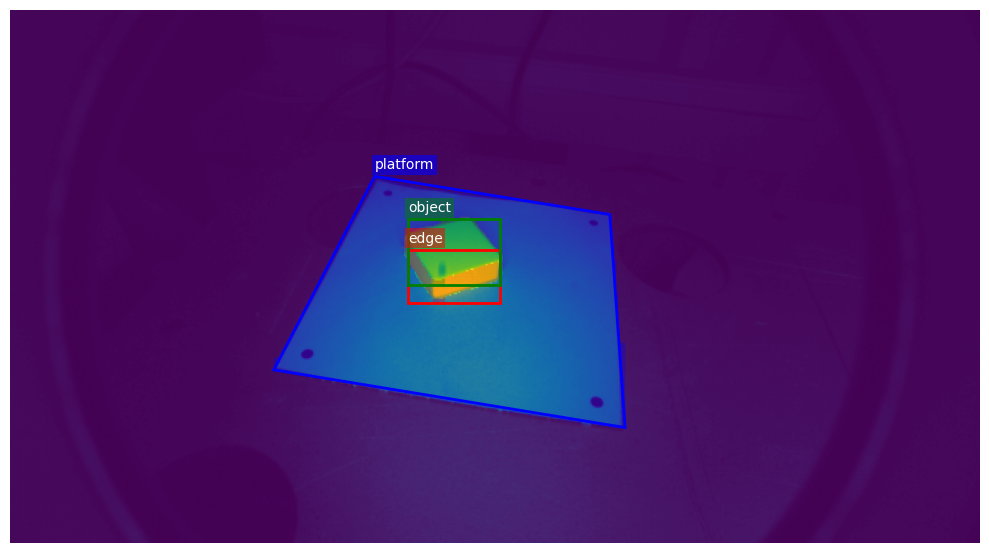

CPU times: total: 500 ms
Wall time: 499 ms


{'angle': 9.22215461730957,
 'coords': (4, 5),
 'edge_mask': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 'platform_mask': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 'object_mask': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])}

In [11]:
%%time
get_data('data/raw/Положение 1/Image__2025-07-15__15-24-18.bmp', True)